Load data

**Import libraries**

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from random import randint

init_notebook_mode(connected=True)
RANDOM_SEED = 123

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Load Data and Plot Samples**

In [2]:
TRAIN_DIR = ('/kaggle/input/facial-recognition-dataset/Training/Training')
TEST_DIR = ('/kaggle/input/facial-recognition-dataset/Testing/Testing')

In [3]:
from torchvision import transforms

IMG_SIZE = (224, 224)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Single channel normalization
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

**Preparing Data for PyTorch**

We need to convert our numpy arrays to PyTorch tensors and create proper datasets and dataloaders.

In [4]:
from torch.utils.data import Dataset

class EmotionImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.labels_map = {}
        self.transform = transform
        label_index = 0

        for folder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                self.labels_map[label_index] = folder
                for file in os.listdir(folder_path):
                    if not file.startswith('.'):
                        file_path = os.path.join(folder_path, file)
                        self.samples.append((file_path, label_index))
                label_index += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 1 channel
        if img is None:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
# Make sure EmotionImageDataset class is already defined before this
train_dataset = EmotionImageDataset(TRAIN_DIR, transform=train_transform)
test_dataset = EmotionImageDataset(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Optional: get label names
train_labels = train_dataset.labels_map
print("Label mapping:", train_labels)

Label mapping: {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}


# Train model

In [10]:
import torchvision.models as models
import torch.nn as nn

class ResNet18EmotionModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        resnet = models.resnet18(pretrained=True)

        # Modify the first conv layer to accept 1 channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Unfreeze the last two layers (layer4 and fc) for fine-tuning
        for param in resnet.layer4.parameters():
            param.requires_grad = True
        for param in resnet.fc.parameters():
            param.requires_grad = True

        # Replace final classification head
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        self.model = resnet

    def forward(self, x):
        return self.model(x)

# Create model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18EmotionModel(num_classes=6).to(device)

In [11]:
from torch.nn import CrossEntropyLoss
from collections import Counter

# Calculate class weights
label_counts = Counter([label for _, label in train_dataset.samples])
num_samples = len(train_dataset)
class_weights = [num_samples / (len(label_counts) * count) for count in label_counts.values()]
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [12]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=40):
    model.train()
    history = {'loss': [], 'accuracy': []}
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        scheduler.step(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

    return history

In [13]:
# Train the model
history = train_model(model, train_loader, criterion, optimizer, device, epochs=40)

Epoch 1/40 - Loss: 1.2712 - Accuracy: 0.5082
Epoch 2/40 - Loss: 1.0249 - Accuracy: 0.6192
Epoch 3/40 - Loss: 0.9231 - Accuracy: 0.6620
Epoch 4/40 - Loss: 0.8565 - Accuracy: 0.6874
Epoch 5/40 - Loss: 0.7827 - Accuracy: 0.7154
Epoch 6/40 - Loss: 0.7234 - Accuracy: 0.7396
Epoch 7/40 - Loss: 0.6588 - Accuracy: 0.7647
Epoch 8/40 - Loss: 0.5965 - Accuracy: 0.7881
Epoch 9/40 - Loss: 0.5337 - Accuracy: 0.8100
Epoch 10/40 - Loss: 0.4796 - Accuracy: 0.8290
Epoch 11/40 - Loss: 0.4272 - Accuracy: 0.8496
Epoch 12/40 - Loss: 0.3769 - Accuracy: 0.8715
Epoch 13/40 - Loss: 0.3425 - Accuracy: 0.8805
Epoch 14/40 - Loss: 0.3045 - Accuracy: 0.8951
Epoch 15/40 - Loss: 0.2846 - Accuracy: 0.9033
Epoch 16/40 - Loss: 0.2534 - Accuracy: 0.9115
Epoch 17/40 - Loss: 0.2453 - Accuracy: 0.9136
Epoch 18/40 - Loss: 0.2091 - Accuracy: 0.9288
Epoch 19/40 - Loss: 0.2046 - Accuracy: 0.9297
Epoch 20/40 - Loss: 0.1787 - Accuracy: 0.9378
Epoch 21/40 - Loss: 0.1802 - Accuracy: 0.9392
Epoch 22/40 - Loss: 0.1634 - Accuracy: 0.94

**Confusion Matrix**

Additionally, the sensitivity, specificity, F-score, and accuracy are calculated for each class by using the following calculated confusion matrix Fig for the six classes for emotion detection. Each class is used against all classes in order to find those performance factors related to it.


In [14]:
# Save the trained model
torch.save(model.state_dict(),'emotion_model.pth')

In [6]:
# 1. Rebuild the model with the same custom fc as training
model = models.resnet18(pretrained=False)

# This matches the keys seen in your error: fc.0.weight, fc.3.bias, etc.
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # fc.0
    nn.ReLU(),                             # fc.1
    nn.Dropout(0.2),                       # fc.2
    nn.Linear(512, 6)                      # fc.3 – change 6 if needed
)

# 2. Load and clean the state_dict
state_dict = torch.load('/kaggle/input/resnet18/pytorch/default/1/emotion_model.pth')
new_state_dict = OrderedDict((k.replace("model.", ""), v) for k, v in state_dict.items())

# 3. Load weights
model.load_state_dict(new_state_dict, strict=True)

# 4. Ready to use
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    # Create a copy of cm to avoid modifying the original
    display_cm = cm.copy()
    if normalize:
        display_cm = display_cm.astype('float') / display_cm.sum(axis=1)[:, np.newaxis]

    # Round the display matrix
    display_cm = np.round(display_cm, 2)

    plt.imshow(display_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = display_cm.max() / 2.
    for i, j in itertools.product(range(display_cm.shape[0]), range(display_cm.shape[1])):
        plt.text(j, i, display_cm[i, j],
                 horizontalalignment="center",
                 color="white" if display_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, device, class_labels, normalize=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Đang đánh giá"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = running_loss / total
    test_acc = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_labels))

    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plot_confusion_matrix(cm, classes=class_labels, normalize=normalize)

    return test_loss, test_acc, all_preds, all_targets

In [18]:
class_labels = list(train_dataset.labels_map.values())
class_labels[5] = "Surprise"  # Fix typo: 'Suprise' -> 'Surprise'
print("Class labels:", class_labels)

Class labels: ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Đang đánh giá: 100%|██████████| 111/111 [00:16<00:00,  6.65it/s]


Test Loss: 1.6831, Test Accuracy: 0.6839

Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.64      0.63       958
        Fear       0.56      0.54      0.55      1024
       Happy       0.88      0.84      0.86      1774
     Neutral       0.63      0.63      0.63      1233
         Sad       0.54      0.61      0.57      1247
    Surprise       0.84      0.77      0.80       831

    accuracy                           0.68      7067
   macro avg       0.68      0.67      0.67      7067
weighted avg       0.69      0.68      0.69      7067



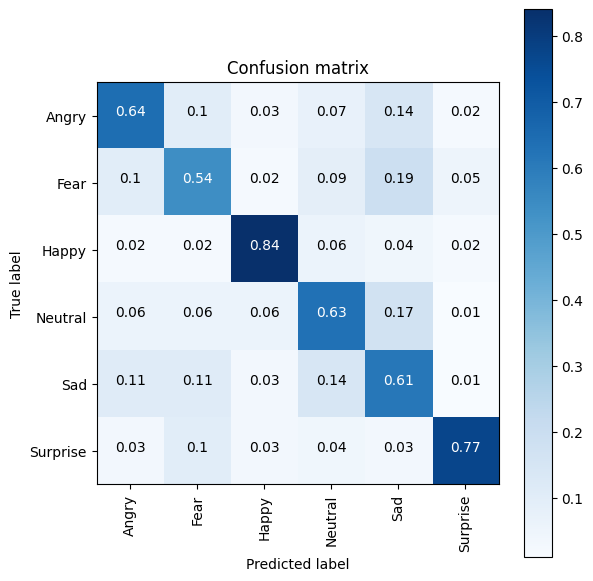

In [19]:
test_loss, test_acc, all_preds, all_targets = evaluate_model(
    model, test_loader, criterion, device, class_labels, normalize=True
)

In [33]:
# Hàm dự đoán cảm xúc cho một ảnh cụ thể
def predict_emotion(model, image_path, device):
    # Đọc và tiền xử lý ảnh
    img = cv2.imread(image_path)
    img = img.astype('float32') / 255
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    
    # Chuyển thành tensor và thêm chiều batch
    img_tensor = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0).to(device)
    
    # Dự đoán
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
    # Lấy class và độ tin cậy
    predicted_class = predicted.item()
    confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence

In [34]:
# Tạo dataset tùy chỉnh cho thư mục test
class EmotionImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(root_dir, target_class)
            for root, _, fnames in os.walk(class_dir):
                for fname in sorted(fnames):
                    if not fname.startswith('.'):
                        path = os.path.join(root, fname)
                        item = (path, self.class_to_idx[target_class])
                        self.samples.append(item)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = cv2.imread(path)
        img = img.astype('float32') / 255
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.FloatTensor(img).permute(2, 0, 1)
            
        return img, target, path

# Tạo dataset và dataloader để lấy đường dẫn file
test_dataset = EmotionImageDataset(TEST_DIR)
test_path_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [35]:
# Tạo dataframe để lưu kết quả dự đoán
filenames = []
predictions = []
actual_classes = []

for img, target, path in test_path_loader:
    # Lấy tên file từ đường dẫn
    filename = os.path.relpath(path[0], TEST_DIR)
    
    # Đọc ảnh và dự đoán
    predicted_class, confidence = predict_emotion(model, path[0], device)
    
    # Lưu kết quả
    filenames.append(filename)
    predictions.append(test_labels[predicted_class])
    actual_classes.append(test_labels[target.item()])

# Tạo dataframe
pred_result = pd.DataFrame({
    "Filename": filenames,
    "Predictions": predictions,
    "Actual Values": actual_classes
})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Sad,Angry
1,Angry/Angry-10.jpg,Neutral,Angry
2,Angry/Angry-100.jpg,Neutral,Angry
3,Angry/Angry-101.jpg,Angry,Angry
4,Angry/Angry-102.jpg,Angry,Angry


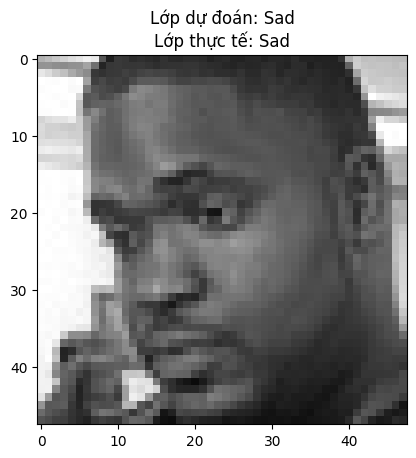

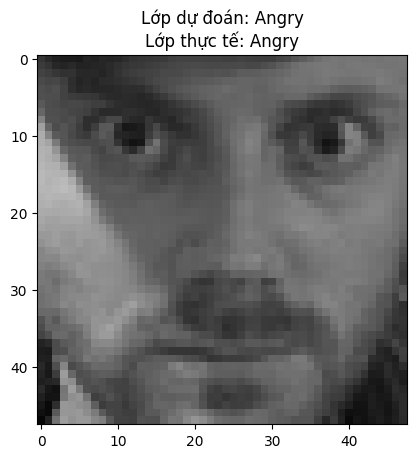

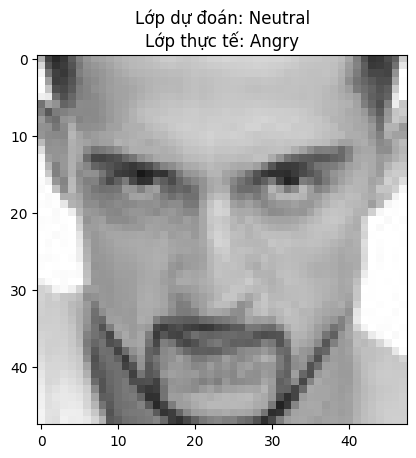

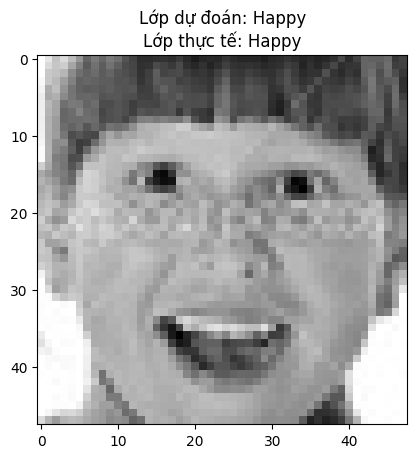

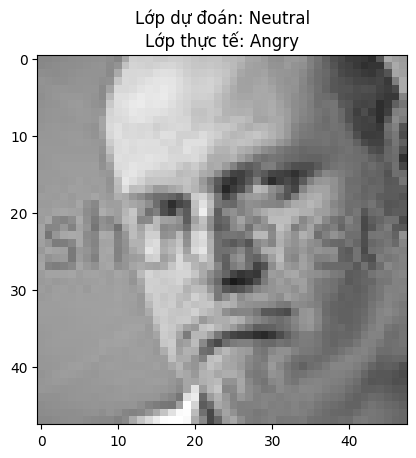

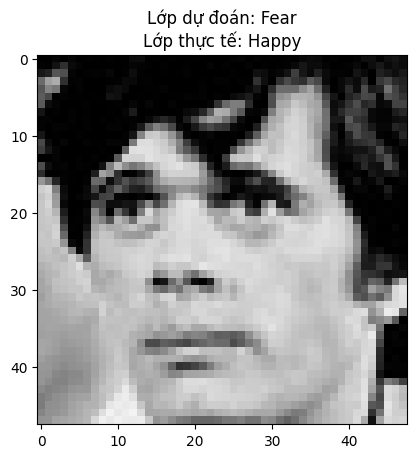

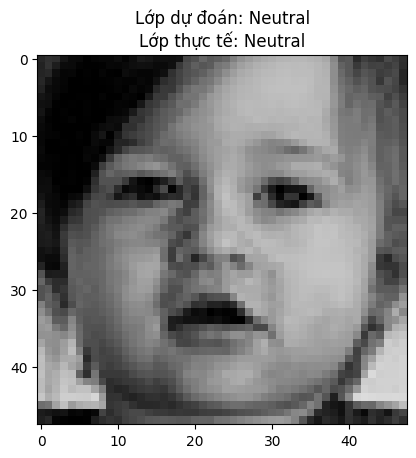

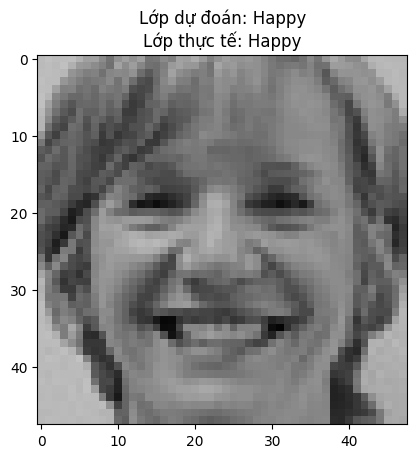

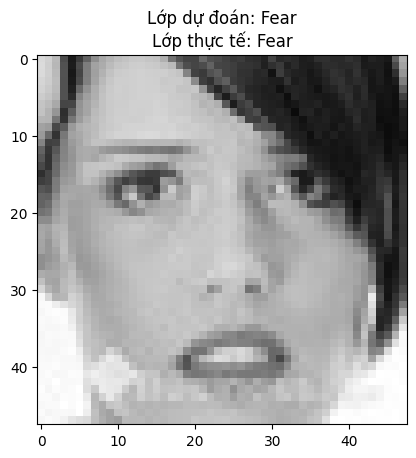

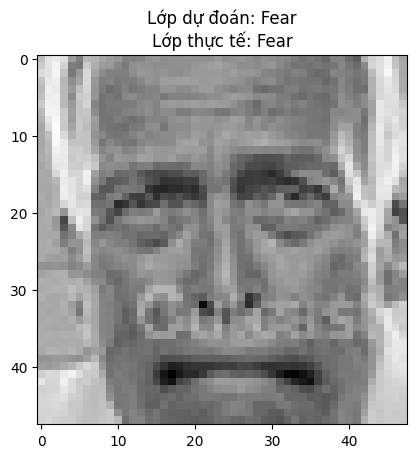

In [36]:
# Hiển thị kết quả dự đoán ngẫu nhiên với hình ảnh
from random import randint

l = len(filenames)
for i in range(10):  # 10 ảnh
    rnd_number = randint(0, l-1)
    filename, pred_class, actual_class = pred_result.iloc[rnd_number]
    
    img_path = os.path.join(TEST_DIR, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Lớp dự đoán: {pred_class}\nLớp thực tế: {actual_class}")
    plt.show()